所需的最小NSIDE值为：4096


Minimum NSIDE required: 32
Number of pixels with NSIDE=32: 12288
The number of pixels is sufficient to ensure each pixel contains at most one galaxy.


In [3]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates.name_resolve import NameResolveError
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import json
import os

# 结果文件路径
results_file = 'ngc_positions.csv'
cache_file = 'ngc_cache.json'

# 创建一个空的数据框来存储结果
if os.path.exists(results_file):
    results = pd.read_csv(results_file)
else:
    results = pd.DataFrame(columns=['NGC', 'RA', 'Dec'])

# 读取缓存
cache = {}
if os.path.exists(cache_file):
    with open(cache_file, 'r') as f:
        cache = json.load(f)

# 查询单个天体的位置信息
def query_ngc(ngc_number):
    name = f'NGC {ngc_number}'
    if name in cache:
        return cache[name]
    try:
        pos = SkyCoord.from_name(name)
        ra = pos.ra.deg
        dec = pos.dec.deg
        data = {'NGC': name, 'RA': ra, 'Dec': dec}
    except NameResolveError:
        data = {'NGC': name, 'RA': None, 'Dec': None}
    cache[name] = data
    return data

# 调试：处理小规模数据
ngc_numbers = range(1, 7840)  # 示例范围

with ThreadPoolExecutor(max_workers=5) as executor:
    future_to_ngc = {executor.submit(query_ngc, num): num for num in ngc_numbers}
    for future in future_to_ngc:
        try:
            ngc_data = future.result()
            if ngc_data['RA'] is not None:
                results = results.append(ngc_data, ignore_index=True)
                print(f"{ngc_data['NGC']}: RA={ngc_data['RA']}, Dec={ngc_data['Dec']}")
            else:
                print(f"Could not resolve {ngc_data['NGC']}")
        except Exception as e:
            print(f"Error processing {future_to_ngc[future]}: {e}")

# 保存结果和缓存
results.to_csv(results_file, index=False)
with open(cache_file, 'w') as f:
    json.dump(cache, f)


NGC 1: RA=1.81606776565, Dec=27.70806114254
NGC 2: RA=1.82131501592, Dec=27.67834301791
NGC 3: RA=1.81999157137, Dec=8.30166015594
NGC 4: RA=1.85167, Dec=8.375
NGC 5: RA=1.95360833127, Dec=35.36226206734
NGC 6: RA=2.0735, Dec=32.5057
NGC 7: RA=2.08733, Dec=-29.915
NGC 8: RA=2.18875, Dec=23.83861
NGC 9: RA=2.22784436212, Dec=23.8168953675
NGC 10: RA=2.14391216689, Dec=-33.85838818249
NGC 11: RA=2.1770583, Dec=37.4478861
NGC 12: RA=2.18642205527, Dec=4.61257438432
NGC 13: RA=2.19881276782, Dec=33.43332612248999
NGC 14: RA=2.192632, Dec=15.816957
NGC 15: RA=2.26032902069, Dec=21.62457371643
NGC 16: RA=2.26781659792, Dec=27.72940935524
NGC 17: RA=2.77755, Dec=-12.1078694
NGC 18: RA=2.3483, Dec=27.7224
NGC 19: RA=2.67031431997, Dec=32.98296057488001
NGC 20: RA=2.38617755398, Dec=33.30874142705
NGC 21: RA=2.6745, Dec=32.9724
NGC 22: RA=2.45084454906, Dec=27.83225757794
NGC 23: RA=2.4725458, Dec=25.9237389
NGC 24: RA=2.4855917, Dec=-24.9631306
NGC 25: RA=2.4970417, Dec=-57.0208056
NGC 26: RA=

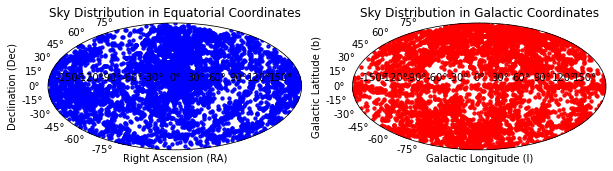

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u

# 读取 CSV 文件
df = pd.read_csv('ngc_positions.csv')

# 提取 RA 和 Dec 数据
ra = df['RA'].values
dec = df['Dec'].values

# 创建赤道坐标系分布图
fig, ax = plt.subplots(1,2,figsize=(10, 5), subplot_kw={'projection': 'mollweide'})
ax[0].set_title('Sky Distribution in Equatorial Coordinates')
# 将 RA 和 Dec 转换为弧度
ra_rad = np.radians(ra - 180)  # RA需要从0到360度转换为-180到180度
dec_rad = np.radians(dec)
ax[0].scatter(ra_rad, dec_rad, s=10, color='blue', alpha=0.7)
ax[0].set_xlabel('Right Ascension (RA)')
ax[0].set_ylabel('Declination (Dec)')
#plt.show()

# 转换到银道坐标系
coords = SkyCoord(ra, dec, unit=(u.deg, u.deg), frame='icrs')
l = coords.galactic.l.deg
b = coords.galactic.b.deg

# 创建银道坐标系分布图
#fig, ax = plt.subplots(1,2,figsize=(10, 5), subplot_kw={'projection': 'mollweide'})
ax[1].set_title('Sky Distribution in Galactic Coordinates')
# 将 l 和 b 转换为弧度
l_rad = np.radians(l - 180)  # l需要从0到360度转换为-180到180度
b_rad = np.radians(b)
ax[1].scatter(l_rad, b_rad, s=10, color='red', alpha=0.7)
ax[1].set_xlabel('Galactic Longitude (l)')
ax[1].set_ylabel('Galactic Latitude (b)')
plt.show()


In [ ]:
## SSY：图例太大，看不出哪里是星系团了

In [5]:
import numpy as np

def calculate_min_nside(num_galaxies):
    # 计算所需的最小 NSIDE
    nside = 1
    while True:
        # 计算像素数量
        num_pixels = 12 * nside**2
        if num_pixels >= num_galaxies:
            return nside
        nside *= 2

def main():
    num_galaxies = 10000  # 可以修改为实际的星系数量
    min_nside = calculate_min_nside(num_galaxies)
    
    # 打印结果
    print(f"Minimum NSIDE required: {min_nside}")
    
    # 验证结果
    num_pixels = 12 * min_nside**2
    print(f"Number of pixels with NSIDE={min_nside}: {num_pixels}")
    if num_pixels >= num_galaxies:
        print("The number of pixels is sufficient to ensure each pixel contains at most one galaxy.")
    else:
        print("The number of pixels is not sufficient.")

if __name__ == "__main__":
    main()

Minimum NSIDE required: 32
Number of pixels with NSIDE=32: 12288
The number of pixels is sufficient to ensure each pixel contains at most one galaxy.


In [ ]:
### SSY: 12哪里来的？